##### Copyright 2018 The TensorFlow Authors.

# **Proj1B - Logistic Regression:** Understanding the ADNI Data Using Regression  

> ### **(34 points) || Due by 9/30 11:59pm**





<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Instructions

Please make a copy and rename it with your name (ex: Proj1B_Ilmi_Yoon). All grading points should be explored in the notebook but some can be done in a separate pdf file. 

*Graded questions will be listed with "Q:" followed by the corresponding points.* 

You will be submitting a **pdf** file containing **the url of your own proj1B.**


---



## Table of Contents

Introduction *(Points: 34)*
1. Load in the Data
2. Clean the Data
3. Inspect the Data
4. Select a Few Features to Work On and Split Features from Labels
5. Normalization

  5.1 The Normalization Layer

6. Logistic Regression

  6.1 One Variable *(Points: 39)*
 
  6.2 Multiple Variable: Features *(Points: 5)*


Conclusion

---



## Introduction

In a **regression** problem, the aim is to *predict the output of a continuous value*, like a price or a probability.

Contrast this with a **classification** problem, where the aim is to *select a class from a list of classes* (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This example uses the `tf.keras API`, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.6.0


### 1. Load in the Data
First download and import the dataset using pandas:

In [4]:
url = "https://raw.githubusercontent.com/pleunipennings/CSC508Data/main/PatData.csv" 
data = pd.read_csv(url)

In [5]:
dataset = data.copy()
dataset.tail()

,PTID,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,DX,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
1732,941_S_4377,69.3,Female,12,Not Hisp/Latino,White,Widowed,1.0,MCI,19850.0,6276.500000,854605.0,3098.750000,14773.000000,16232.75,1.307478e+06
1733,941_S_4420,81.4,Male,18,Not Hisp/Latino,White,Married,0.0,MCI,45450.5,7542.250000,1125837.5,4501.750000,16491.250000,17802.75,1.658722e+06
1734,941_S_4764,82.7,Female,20,Not Hisp/Latino,White,Never married,0.0,MCI,63228.5,6092.500000,915772.5,3933.666667,17667.333333,17832.00,1.483815e+06
1735,941_S_5124,76.7,Female,20,Not Hisp/Latino,White,Married,0.0,NL,NaN,4691.666667,NaN,NaN,NaN,NaN,1.489683e+06
1736,941_S_5193,72.5,Female,16,Not Hisp/Latino,White,Married,0.0,NL,22958.5,7009.500000,1026105.0,4007.500000,15812.500000,17461.00,1.465065e+06


In [6]:
dataset['DX'].value_counts()

MCI                586
Dementia           577
NL                 423
MCI to Dementia    108
NL to MCI           29
NL to Dementia       3
MCI to NL            3
Dementia to MCI      1
Name: DX, dtype: int64

So, I would like to take out everything in the dataset **EXCEPT** the following levels: NL and Dementia (for binary classification for now). 

*NL = cognitively normal , MCI = mild cognitive impairement.*

In [7]:
index_to_drop = dataset[ (dataset['DX'] != "NL") & (dataset['DX'] != "Dementia")].index
  
# drop these given row indices from data
dataset = dataset.drop(index_to_drop)

In [8]:
dataset['DX'].value_counts()

Dementia    577
NL          423
Name: DX, dtype: int64

### 2. Clean the Data

The dataset contains a few unknown values. To see how many unknown values, use the following code:

In [9]:
dataset.isna().sum()

PTID            0
AGE             0
PTGENDER        0
PTEDUCAT        0
PTETHCAT        0
PTRACCAT        0
PTMARRY         0
APOE4           3
DX              0
Ventricles     16
Hippocampus    39
WholeBrain     10
Entorhinal     70
Fusiform       70
MidTemp        70
ICV             1
dtype: int64

In [10]:
dataset = dataset.dropna()

In [11]:
cleanup_DX = {"DX": {"NL": 0, "Dementia": 1}}
dataset = dataset.replace(cleanup_DX)

In [12]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### 3. Inspect the Data

Have a quick look at the joint distribution of a few pairs of columns from the training set. *Can you find the data that show their relationship clearly?*


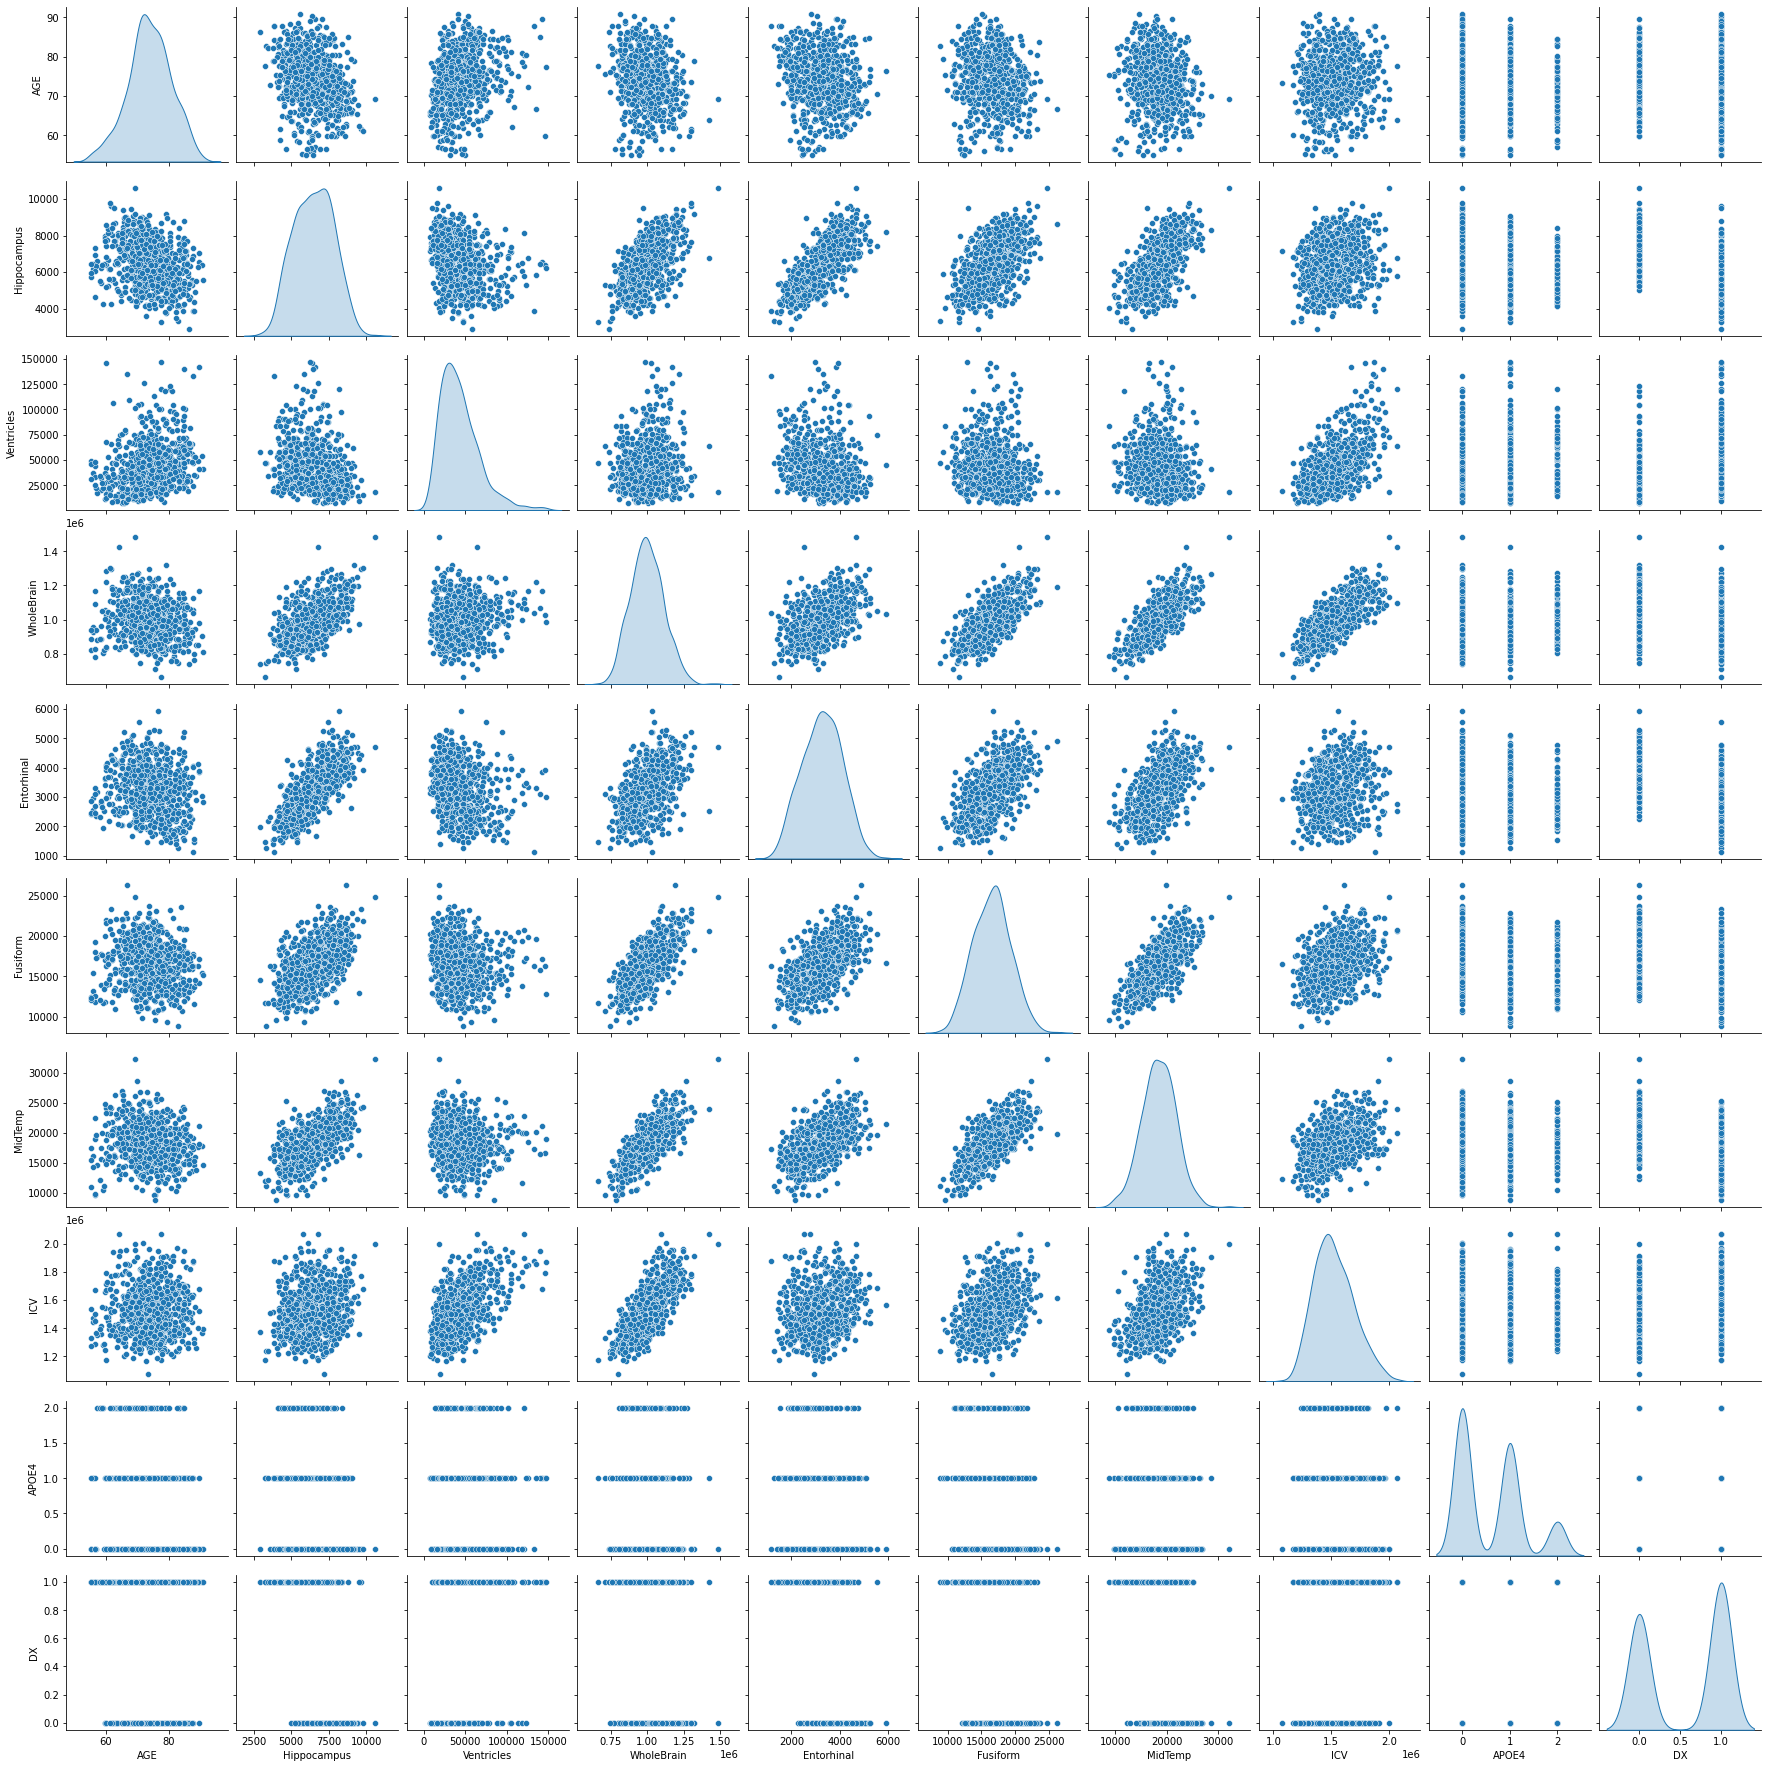

In [13]:
sns.pairplot(train_dataset[["AGE", "Hippocampus", "Ventricles", "WholeBrain", "Entorhinal", "Fusiform", "MidTemp", "ICV", "APOE4", "DX"]], diag_kind="kde")

Also look at the overall statistics, note how each feature covers a very different range:

In [14]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AGE,736.0,7.378791e+01,6.806120,5.510000e+01,6.960000e+01,7.365000e+01,7.840000e+01,9.090000e+01
PTEDUCAT,736.0,1.583696e+01,2.872444,4.000000e+00,1.400000e+01,1.600000e+01,1.800000e+01,2.000000e+01
APOE4,736.0,6.141304e-01,0.684536,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00
DX,736.0,5.597826e-01,0.496751,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Ventricles,736.0,4.327182e+04,23584.973866,7.296000e+03,2.625521e+04,3.898842e+04,5.501240e+04,1.466654e+05
Hippocampus,736.0,6.486026e+03,1308.283103,2.894500e+03,5.482333e+03,6.509250e+03,7.480625e+03,1.060200e+04
WholeBrain,736.0,9.979635e+05,113931.813643,6.616225e+05,9.194966e+05,9.944984e+05,1.073055e+06,1.486040e+06
Entorhinal,736.0,3.265773e+03,827.521722,1.143000e+03,2.649300e+03,3.283893e+03,3.861250e+03,5.931000e+03
Fusiform,736.0,1.653037e+04,2772.075954,8.863667e+03,1.452794e+04,1.661283e+04,1.834190e+04,2.629933e+04
MidTemp,736.0,1.847502e+04,3309.121895,8.850333e+03,1.631933e+04,1.846588e+04,2.069904e+04,3.218900e+04


### 4. Select a Few Features to Work On and Split Features from Labels

Separate the target value (the "label") from the features. 

**This label is the value that you will train the model to predict.**

In [15]:
train_features = train_dataset[["Hippocampus", "WholeBrain", "Entorhinal", "AGE"]]
test_features = test_dataset[["Hippocampus", "WholeBrain", "Entorhinal", "AGE"]]


train_labels = train_dataset["DX"]
test_labels = test_dataset["DX"]

## 5. Normalization

In the table of statistics, it's easy to see how different the ranges of each feature are. You can use `.describe().transpose()[['examplefeature']]` to see this.



In [16]:
train_features.describe().transpose()[['mean', 'std']]

,mean,std
Hippocampus,6486.025883,1308.283103
WholeBrain,997963.549634,113931.813643
Entorhinal,3265.773175,827.521722
AGE,73.787908,6.806120


### 5.1 The Normalization Layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [17]:
normalizer = preprocessing.Normalization(axis=-1)

Then `.adapt()` it to the data:

In [18]:
normalizer.adapt(np.array(train_features))

The following code calculates the mean and variance, and stores them in the layer. 

In [19]:
print(normalizer.mean.numpy())

[[  6486.026 997963.44    3265.772     73.788]]


When the layer is called, it returns the input data with each feature independently normalized:

In [20]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  7484.17 973624.     3232.       72.6 ]]

Normalized: [[ 0.76 -0.21 -0.04 -0.17]]


## 6. Logistic regression



### 6.1. One Variable

Start with a single-variable linear regression, to predict `DX` from `hippocampus`.



First, create the hippocampus `Normalization` layer:

In [22]:
one_feature = np.array(train_features['Hippocampus'])


one_feature_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
one_feature_normalizer.adapt(one_feature)

Then, build the sequential model:

In [23]:
from tensorflow.keras.layers import Dense
from keras.utils import np_utils

one_feature_model = tf.keras.Sequential([
    one_feature_normalizer
])

nb_classes = 2
number_of_features = 1 #X_train.shape[1]
train_lables_in_classes = np_utils.to_categorical( train_labels,nb_classes )



Q: **(2 points)** What is the difference between train_labels and train_labes_in_classes?

In [24]:

one_feature_model.add(Dense(nb_classes,activation = 'sigmoid',input_dim = number_of_features))
#hippocampus_model.add(Dense(nb_classes,activation = 'softmax',input_dim = number_of_features))
one_feature_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.fit(x, y, epoch=10, validation_data=(x_val, y_val))

one_feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 2)                 4         
Total params: 7
Trainable params: 4
Non-trainable params: 3
_________________________________________________________________


Q: **(5 points)** Explain what is activation? What is sigmoid? What is Softmax? What is categorical_crossentropy? Please answer 300 words or more to answer all the questions.

Thus, this model will predict `DX` from `hippocampus`.

Run the untrained model on the first 10 horse-power values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [26]:
one_feature_model.predict(one_feature[:10])

array([[0.439, 0.312],
       [0.408, 0.234],
       [0.52 , 0.565],
       [0.516, 0.552],
       [0.557, 0.675],
       [0.502, 0.505],
       [0.465, 0.391],
       [0.457, 0.367],
       [0.422, 0.267],
       [0.372, 0.159]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` - since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [27]:
%%time
history = one_feature_model.fit(
    train_features['Hippocampus'], train_lables_in_classes,
    epochs=100, batch_size=16,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
37/37 [==============================] - 1s 10ms/step - loss: 0.5301 - accuracy: 0.8112 - val_loss: 0.4835 - val_accuracy: 0.8514
Epoch 2/100
37/37 [==============================] - 0s 4ms/step - loss: 0.5202 - accuracy: 0.8078 - val_loss: 0.4704 - val_accuracy: 0.8378
Epoch 3/100
37/37 [==============================] - 0s 4ms/step - loss: 0.5115 - accuracy: 0.8129 - val_loss: 0.4588 - val_accuracy: 0.8378
Epoch 4/100
37/37 [==============================] - 0s 5ms/step - loss: 0.5040 - accuracy: 0.8146 - val_loss: 0.4487 - val_accuracy: 0.8446
Epoch 5/100
37/37 [==============================] - 0s 4ms/step - loss: 0.4975 - accuracy: 0.8146 - val_loss: 0.4398 - val_accuracy: 0.8446
Epoch 6/100
37/37 [==============================] - 0s 4ms/step - loss: 0.4916 - accuracy: 0.8163 - val_loss: 0.4324 - val_accuracy: 0.8446
Epoch 7/100
37/37 [==============================] - 0s 4ms/step - loss: 0.4868 - accuracy: 0.8163 - val_loss: 0.4253 - val_accuracy: 0.8378
Epoch 8/100


Visualize the model's training progress using the stats stored in the `history` object.

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,0.448817,0.809524,0.361417,0.831081,95
96,0.448868,0.809524,0.361480,0.831081,96
97,0.448864,0.809524,0.361502,0.831081,97
98,0.448881,0.809524,0.361392,0.831081,98
99,0.448933,0.811224,0.361297,0.831081,99


In [29]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [DX]')
  plt.legend()
  plt.grid(True)

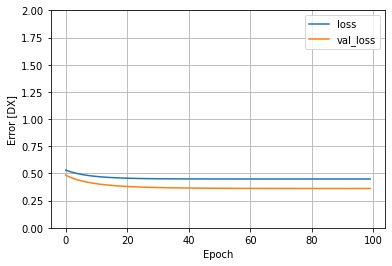

In [30]:
plot_loss(history)

Collect the results on the test set and save for later:

In [32]:
test_results = {}
test_lables_in_classes = np_utils.to_categorical( test_labels,nb_classes )

test_results['hippocampus_model'] = one_feature_model.evaluate(
    test_features['Hippocampus'],
    test_lables_in_classes , verbose=1)

6/6 [==============================] - 0s 3ms/step - loss: 0.4310 - accuracy: 0.7609


In [37]:
test_pred = one_feature_model.predict(test_features['Hippocampus'])
preds_classes = np.argmax(test_pred, axis=-1)
preds_classes
cm = metrics.confusion_matrix( test_labels, preds_classes)

In [38]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[50 24]
 [20 90]]


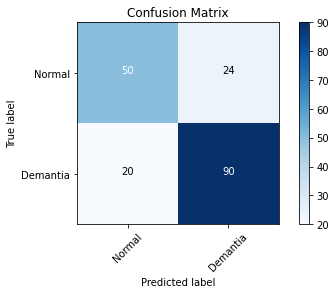

In [39]:
cm_plot_labels = ['Normal','Demantia']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Q: **(10 points)** What does this confusion matrix tell you? Try different activation and different hyperparameters to improve the results. Write about what you've learned in 300 or more words.

### 6.2. Multiple Variables (Features)

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

Q: **(5 points)** Please use Proj1A multiple variables section and the logistics regression using 1 variable to make this Multiple variable logistic regression or classification work!

# Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

* [Mean Squared Error (MSE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanSquaredError) and [Mean Absolute Error (MAE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanAbsoluteError) are common loss functions used for regression problems. Mean Absolute Error is less sensitive to outliers. Different loss functions are used for classification problems.
* Similarly, evaluation metrics used for regression differ from classification.
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* Overfitting is a common problem for DNN models, it wasn't a problem for this tutorial. See the [overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.
